In [202]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [6]:
import re
import gensim
from gensim import corpora, models, similarities

%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import seaborn as sns  
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_pickle("data/hilary_sent.pkl")
df_cut = df[['Id','ExtractedBodyText']].dropna()

In [354]:
df_drop = df_cut.drop_duplicates(subset=['ExtractedBodyText'], keep='first')

# Text Pre-processing 

In [9]:
def clean_email_text(text):
    text = text.replace('\n'," ") # Take out the paragraph space
    text = re.sub(r"-", " ", text) # Split the words with "-" (for example：pre-processing ==> pre processing）
    text = re.sub(r"\d+/\d+/\d+", "", text) # Take out the dates
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text) # Take out the time
    text = re.sub(r"[\w]+@[\.\w]+", "", text) # Take out the emails
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) # Take out the websites
    pure_text = ''
    # Validate to check if there are any non-text content 
    for letter in text:
        # Keep only letters and spaces
        if letter.isalpha() or letter==' ':
            pure_text += letter
    # Join the words are not stand-alone letters
    text = ' '.join(word for word in pure_text.split() if len(word)>1)
    return text

In [355]:
docs = df_drop['ExtractedBodyText']
docs = docs.apply(lambda x: clean_email_text(x))

In [356]:
docs

4       Friday March PM Huma Abedin Fw Latest How Syri...
5       Pis print Wednesday September PM Fw Meet The R...
7       Friday March PM Huma Abedin Fw Latest How Syri...
20      Wednesday September PM Fw Fwd more on libya Li...
21      Pis print Wednesday September PM Fw Fwd more o...
                              ...                        
7823    Lets do Tues evening Do you know when can see ...
7825                                     Could we move to
7826    Did you andor PIR talk to him today Do need to...
7827    Pls prepare condolence letter to Justice RBG f...
7828                Wednesday June PM Fw confidential Fyi
Name: ExtractedBodyText, Length: 1696, dtype: object

In [203]:
def remove_n(t):
    t=t.replace('\n'," ")
    return t

In [357]:
raw = df_drop['ExtractedBodyText']

In [358]:
raw_removed = raw.apply(lambda x: remove_n(x))

In [359]:
doclist = docs.values

In [207]:
stop_words = ENGLISH_STOP_WORDS.union(word for word in ['docx','fyi','fw','get','see','ok','pm','whose','would','pls','thx','yes','print','okay','pis'])

# Topic Modeling

## spaCy

In [400]:
import spacy
import re
import string
# Create our list of punctuation marks
punctuations = string.punctuation
# Load English tokenizer, tagger, parser, NER and word vectors
parser = spacy.load('en_core_web_sm')
# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return ' '.join(mytokens)

In [401]:
docs_lemma = docs.apply(lambda x: spacy_tokenizer(x))

In [422]:
docs_lemma

4       friday march pm huma abedin fw latest syria ai...
5       pis print wednesday september pm fw meet right...
7       friday march pm huma abedin fw latest syria ai...
20      wednesday september pm fw fwd libya libya sept...
21      pis print wednesday september pm fw fwd libya ...
                              ...                        
7823                         let tue evening know maryann
7825                                                     
7826                   andor pir talk today need tomorrow
7827    pls prepare condolence letter justice rbg loss...
7828                wednesday june pm fw confidential fyi
Name: ExtractedBodyText, Length: 1696, dtype: object

## TF-IDF

In [402]:
tfidf_vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)

word_matrix = tfidf_vectorizer.fit_transform(docs_lemma)

vocab = tfidf_vectorizer.get_feature_names()

## pyLDA

In [209]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [405]:
lda_tfidf = LatentDirichletAllocation(n_components=3, random_state=0)
lda_tfidf.fit(word_matrix)

LatentDirichletAllocation(n_components=3, random_state=0)

In [406]:
pyLDAvis.sklearn.prepare(lda_tfidf, word_matrix, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.085527  0.013848       1        1  41.072047
2      0.027230 -0.064108       2        1  33.246743
0      0.058298  0.050260       3        1  25.681210, topic_info=       Term       Freq      Total Category  logprob  loglift
2351     ok  24.000000  24.000000  Default  30.0000  30.0000
2606  print  19.000000  19.000000  Default  29.0000  29.0000
2534    pls  27.000000  27.000000  Default  28.0000  28.0000
1823   know  19.000000  19.000000  Default  27.0000  27.0000
2537     pm  16.000000  16.000000  Default  26.0000  26.0000
...     ...        ...        ...      ...      ...      ...
1949   list   2.899734   7.631506   Topic3  -5.8678   0.3917
1898  leave   2.730910   7.133205   Topic3  -5.9278   0.3993
2212    mtg   2.680966   8.069830   Topic3  -5.9462   0.2575
1544    hrc   2.114616   4.007445   Topic3  -6.1835   0.7201
2518    pis   2.577514  13.868074   Topic3  -5.9856  -0.3234

[179 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
39        1  0.259585    add
39        2  0.129793    add
39        3  0.519171    add
75        2  0.855642  agree
75        3  0.142607  agree
...     ...       ...    ...
3674      2  0.453247   work
3674      3  0.075541   work
3690      2  0.877815  write
3703      2  0.723018   yeah
3706      1  1.010078    yes

[218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

## Topic Matrix

In [407]:
topic_matrix = lda_tfidf.transform(word_matrix)

topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df

,topic_0,topic_1,topic_2
0,0.589528,0.323873,0.086600
1,0.833377,0.108970,0.057653
2,0.589528,0.323873,0.086600
3,0.343020,0.267296,0.389684
4,0.257552,0.377110,0.365338
...,...,...,...
1691,0.107271,0.107962,0.784767
1692,0.333333,0.333333,0.333333
1693,0.100767,0.791817,0.107416
1694,0.086351,0.096737,0.816911


## Word and Topic Matrix

In [408]:
lda_tfidf.components_

array([[0.33551003, 0.38946199, 0.64537334, ..., 0.77304925, 0.3350642 ,
        0.33654228],
       [0.39647809, 0.33477005, 0.33400936, ..., 0.33660095, 0.77278588,
        0.98107535],
       [0.69464071, 0.33588495, 0.33404147, ..., 1.49405471, 0.33456868,
        0.39132115]])

In [409]:
word_topic_matrix_df = pd.DataFrame(lda_tfidf.components_, columns=vocab).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2
aar,0.335510,0.396478,0.694641
abandon,0.389462,0.334770,0.335885
abbas,0.645373,0.334009,0.334041
abclel,0.365885,0.333776,0.333584
abd,0.334637,0.780330,0.335317


In [444]:
word_topic_matrix_df.to_pickle("data/word_topic_matrix_df.pkl")

## Put the Dataframes Together

In [410]:
topic_matrix_df

,topic_0,topic_1,topic_2
0,0.589528,0.323873,0.086600
1,0.833377,0.108970,0.057653
2,0.589528,0.323873,0.086600
3,0.343020,0.267296,0.389684
4,0.257552,0.377110,0.365338
...,...,...,...
1691,0.107271,0.107962,0.784767
1692,0.333333,0.333333,0.333333
1693,0.100767,0.791817,0.107416
1694,0.086351,0.096737,0.816911


In [436]:
topic_matrix_df['Id'] = df_drop['Id'].values

In [411]:
topic_matrix_df['clean_email'] = doclist

topic_matrix_df['raw_email'] = raw_removed.values

In [412]:
#word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(20)

In [427]:
for email in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(20)['raw_email'].values:
    print(email)
    print()

Another report-- SOURCE: Sources with direct access to the Libyan National Transitional Council, as well as the highest levels of European Governments, and Western Intelligence and security services. 1. As of the morning of July 6, an individual with access to the information stated in confidence that Libyan National Transitional Council (NTC) President Mustafa Abdel Jalil remains committed to a transfer of power to a popularly elected government; however, he is prepared to ex-tend the life of the NTC as a guarantor of stability for the Libyan people following the July 7, 2012 election for seats in a 200-member General National Congress (GNC). Jaifi realizes that 2.7 million Libyans have registered to vote and are generally anxious to replace the increasingly unpopular NTC. That said, JAI expects the voting to lead to a period of confusion and he will not abandon his authority until the results are fixed. 2. Jalil is also frustrated by the fact that during its eight-month tenure of the

In [441]:
import pickle

In [442]:
topic_matrix_df.to_pickle('data/hilary_sent_topics.pkl')

In [443]:
topic_matrix_df.to_csv('data/hilary_sent_topics.csv', index = False)

# KMean

In [225]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

In [299]:
def display_cluster(X, km=[], num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], c=color[0], alpha=alpha, s=s)
        
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

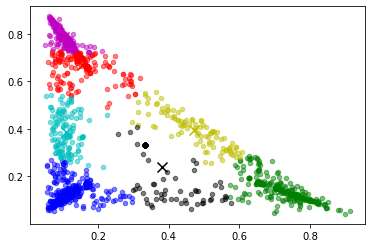

In [418]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters)
km.fit(topic_matrix)
display_cluster(topic_matrix,km,num_clusters)

# LDA Model

In [15]:
stoplist = ['very', 'ourselves', 'am', 'doesn', 'through', 'me', 'against', 'up', 'just', 'her', 'ours', 
            'couldn', 'because', 'is', 'isn', 'it', 'only', 'in', 'such', 'too', 'mustn', 'under', 'their', 
            'if', 'to', 'my', 'himself', 'after', 'why', 'while', 'can', 'each', 'itself', 'his', 'all', 'once', 
            'herself', 'more', 'our', 'they', 'hasn', 'on', 'ma', 'them', 'its', 'where', 'did', 'll', 'you', 
            'didn', 'nor', 'as', 'now', 'before', 'those', 'yours', 'from', 'who', 'was', 'm', 'been', 'will', 
            'into', 'same', 'how', 'some', 'of', 'out', 'with', 's', 'being', 't', 'mightn', 'she', 'again', 'be', 
            'by', 'shan', 'have', 'yourselves', 'needn', 'and', 'are', 'o', 'these', 'further', 'most', 'yourself', 
            'having', 'aren', 'here', 'he', 'were', 'but', 'this', 'myself', 'own', 'we', 'so', 'i', 'does', 'both', 
            'when', 'between', 'd', 'had', 'the', 'y', 'has', 'down', 'off', 'than', 'haven', 'whom', 'wouldn', 
            'should', 've', 'over', 'themselves', 'few', 'then', 'hadn', 'what', 'until', 'won', 'no', 'about', 
            'any', 'that', 'for', 'shouldn', 'don', 'do', 'there', 'doing', 'an', 'or', 'ain', 'hers', 'wasn', 
            'weren', 'above', 'a', 'at', 'your', 'theirs', 'below', 'other', 'not', 're', 'him', 'during', 'which']

In [136]:
texts = [[word for word in doc.lower().split() if word not in stop_words] for doc in doclist]

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [71]:
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20)

In [72]:
lda.print_topics(num_topics=20, num_words=5)

[(0,
  '0.009*"want" + 0.008*"friday" + 0.008*"need" + 0.007*"memo" + 0.007*"sid"'),
 (1,
  '0.012*"pis" + 0.009*"im" + 0.007*"huma" + 0.007*"know" + 0.007*"tonight"'),
 (2,
  '0.010*"state" + 0.010*"like" + 0.008*"time" + 0.007*"want" + 0.007*"add"'),
 (3,
  '0.015*"im" + 0.013*"did" + 0.011*"discuss" + 0.009*"ops" + 0.009*"schedule"'),
 (4,
  '0.014*"press" + 0.013*"doc" + 0.013*"talk" + 0.012*"dialogue" + 0.012*"clips"'),
 (5, '0.013*"know" + 0.009*"week" + 0.008*"lets" + 0.006*"id" + 0.005*"like"'),
 (6,
  '0.025*"pis" + 0.014*"release" + 0.012*"tomorrow" + 0.009*"know" + 0.009*"thought"'),
 (7,
  '0.014*"pis" + 0.012*"state" + 0.011*"list" + 0.009*"tomorrow" + 0.009*"did"'),
 (8,
  '0.012*"tomorrow" + 0.011*"great" + 0.009*"work" + 0.008*"good" + 0.007*"sounds"'),
 (9, '0.011*"know" + 0.009*"good" + 0.009*"im" + 0.008*"lets" + 0.008*"talk"'),
 (10,
  '0.016*"pis" + 0.009*"send" + 0.007*"email" + 0.006*"want" + 0.006*"speech"'),
 (11,
  '0.018*"know" + 0.012*"im" + 0.009*"time" + 0

# Word2Vec

In [73]:
model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1, workers=2, sg=1)

In [74]:
list(model.wv.vocab.items())

[('friday', <gensim.models.keyedvectors.Vocab at 0x7f93ca283af0>),
 ('march', <gensim.models.keyedvectors.Vocab at 0x7f93cf9010a0>),
 ('huma', <gensim.models.keyedvectors.Vocab at 0x7f93cc345f40>),
 ('abedin', <gensim.models.keyedvectors.Vocab at 0x7f93cc3455e0>),
 ('latest', <gensim.models.keyedvectors.Vocab at 0x7f93cc345fa0>),
 ('syria', <gensim.models.keyedvectors.Vocab at 0x7f93cd9d8f70>),
 ('aiding', <gensim.models.keyedvectors.Vocab at 0x7f93cd9d8fd0>),
 ('qaddafi', <gensim.models.keyedvectors.Vocab at 0x7f93cd9d8e20>),
 ('sid', <gensim.models.keyedvectors.Vocab at 0x7f93cd9d8fa0>),
 ('hrc', <gensim.models.keyedvectors.Vocab at 0x7f93cd9d8d60>),
 ('memo', <gensim.models.keyedvectors.Vocab at 0x7f93cb490550>),
 ('libya', <gensim.models.keyedvectors.Vocab at 0x7f93cb490940>),
 ('pis', <gensim.models.keyedvectors.Vocab at 0x7f93cb490760>),
 ('wednesday', <gensim.models.keyedvectors.Vocab at 0x7f93cb490700>),
 ('september', <gensim.models.keyedvectors.Vocab at 0x7f93cb490580>),
 ('m

In [29]:
print(model.wv['benghazi'])

[-1.3744071e-01  2.1587807e-01  2.0902865e-01  1.4564884e-01
 -1.2782425e-01  1.9792040e-01 -1.0587117e-01  1.7459910e-01
 -5.1607843e-02  1.5084288e-01 -9.9735267e-02  2.9465685e-02
  1.7406812e-01  1.6365130e-01  5.3840049e-02  1.7888747e-01
  7.3124193e-02 -7.7356085e-02  6.5710761e-02  6.8378076e-02
 -1.0586783e-01  1.3181430e-01  1.2418494e-01  2.6966127e-02
  4.0494174e-02 -3.7634242e-02  5.3996742e-02  1.8736485e-01
 -1.8742085e-01  1.6028783e-01 -2.5258368e-01  2.3633880e-03
  2.3891433e-01 -2.0739751e-02  1.3992932e-01 -1.2231517e-01
  1.4331503e-01 -2.0111375e-01 -2.2342625e-01  2.2868878e-01
  3.3411391e-02  1.0723253e-01  3.0729417e-02  1.6988139e-01
  1.8455836e-01  4.3175962e-02 -1.4618760e-01  4.0477823e-04
 -2.7955461e-01  4.6051618e-02 -6.3923299e-03 -2.4955556e-01
  1.6992606e-01 -1.8006587e-02  1.7565595e-01 -1.6663048e-02
 -1.2433256e-01  4.5467220e-02 -2.1130955e-01  4.0590316e-02
 -2.6200250e-01 -6.8894781e-02 -1.0786487e-02  1.2509571e-01
  9.4524845e-02  8.97383

In [65]:
model.wv.most_similar('benghazi' ,topn=10)

[('comm', 0.9994080662727356),
 ('select', 0.9991276264190674),
 ('agreement', 0.9990670680999756),
 ('subject', 0.9989519715309143),
 ('house', 0.9988731145858765),
 ('sensitive', 0.9986786842346191),
 ('information', 0.998456597328186),
 ('foia', 0.9982517957687378),
 ('redactions', 0.998194694519043),
 ('waiver', 0.9980608224868774)]

In [44]:
model.wv.similarity('ive','us')

0.9994151

# Multiprocessing

In [58]:
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from nltk import bigrams
from collections import defaultdict

In [46]:
cores = multiprocessing.cpu_count()

In [50]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [53]:
sent = [row.split() for row in docs]

In [55]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [445]:
sentences = bigrams[sent]

In [446]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [59]:
phrases